In [12]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import reverse_geocoder as rg



In [13]:
planet_bboxes = gpd.read_file('../aux-data/planet_bboxes_epsg3035.gpkg')

In [14]:
dict_luisa_class = {
1111:'High density urban fabric',
1121:'Medium density urban fabric',
1122:'Low density urban fabric',
1123:'Isolated or very low density urban fabric',
1130:'Urban vegetation',
1210:'Industrial or commercial units',
1221:'Road and rail networks and associated land',
1222:'Major stations',
1230:'Port areas',
1241:'Airport areas',
1242:'Airport terminals',
1310:'Mineral extraction sites',
1320:'Dump sites',
1330:'Construction sites',
1410:'Green urban areas',
1421:'Sport and leisure green',
1422:'Sport and leisure built-up',
2110:'Non irrigated arable land',
2120:'Permanently irrigated land',
2130:'Rice fields',
2210:'Vineyards',
2220:'Fruit trees and berry plantations',
2230:'Olive groves',
2310:'Pastures',
2410:'Annual crops associated with permanent crops',
2420:'Complex cultivation patterns',
2430:'Land principally occupied by agriculture',
2440:'Agro-forestry areas',
3110:'Broad-leaved forest',
3120:'Coniferous forest',
3130:'Mixed forest',
3210:'Natural grassland',
3220:'Moors and heathland',
3230:'Sclerophyllous vegetation',
3240:'Transitional woodland shrub',
3310:'Beaches, dunes and sand plains',
3320:'Bare rock',
3330:'Sparsely vegetated areas',
3340:'Burnt areas',
3350:'Glaciers and perpetual snow',
4000:'Wetlands',
5110:'Water courses',
5120:'Water bodies',
5210:'Coastal lagoons',
5220:'Estuaries',
5230:'Sea and ocean',
}

list_classes_int = [x for x,y in dict_luisa_class.items()]
list_classes_str = [y for x,y in dict_luisa_class.items()]



In [15]:
planet_bboxes_wgs84 = planet_bboxes.to_crs('epsg:4326')

In [16]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="myapp")



In [17]:
str_list_places = []
i = 0

for geometry in planet_bboxes_wgs84.geometry:
    x,y = geometry.centroid.xy
    location = geolocator.reverse(f'{y[0]}, {x[0]}')

    str_list_places.append(f'ID: {i}, {location.address.split(",")[-1]},{location.address.split(",")[-5]}')

    i+=1


In [18]:
str_list_places

['ID: 0,  United Kingdom, Hampshire',
 'ID: 1,  Ελλάς, Περιφερειακή Ενότητα Λασιθίου',
 'ID: 2,  United Kingdom, West Sussex',
 'ID: 3,  United Kingdom, West Sussex',
 'ID: 4,  United Kingdom, Cambridgeshire',
 'ID: 5,  United Kingdom, Surrey',
 'ID: 6,  Србија,Сремска Митровица',
 'ID: 7,  Србија, Општина Алибунар',
 'ID: 8,  Polska, gmina Baborów',
 'ID: 9,  United Kingdom, North Northamptonshire',
 'ID: 10,  Србија,Уздин']

In [19]:
nr_bboxes = planet_bboxes.shape[0]
nr_classes = len(list_classes_int)

In [20]:
arr_counts = np.array(np.zeros([nr_bboxes, nr_classes]).astype(int))

In [21]:
from luisanet import sampling

In [22]:


for i in range(nr_bboxes):

    window = planet_bboxes.geometry[i].bounds

    sample_window = sampling.WindowSampler(input_urls = ['http://92.111.153.194:9000/eumap/lcv/lcv_landcover_luisa_jrc_30m_0..0cm_2018_eumap_epsg3035_v0.1.tif'],
                                window=window)

    list_classes = list(sample_window.input_data[0,:,:].flatten())

    list_unique_classes = np.unique(list_classes)

    counts = {value: list_classes.count(value) for value in list_unique_classes}

    for entry in counts.items():

        class_index = np.where(list_classes_int == entry[0])[0][0]

        arr_counts[i,class_index] = int(entry[1])





In [23]:
import seaborn as sns

In [24]:
def get_shortened_integer(number_to_shorten):
    """ Takes integer and returns a formatted string """

    if number_to_shorten == 0:
        return 0
    trailing_zeros = np.floor(np.log10(abs(number_to_shorten)))
    if trailing_zeros < 3:
        # Ignore everything below 1000
        return str(int(trailing_zeros))
    elif 3 <= trailing_zeros <= 5:
        # Truncate thousands, e.g. 1.3k
        return str(int(round(number_to_shorten/(10**3), 0))) + 'k'
    elif 6 <= trailing_zeros <= 8:
        # Truncate millions like 3.2M
        return str(int(round(number_to_shorten/(10**6), 0))) + 'M'
    else:
        raise ValueError('Values larger or equal to a billion not supported')

In [26]:
pdf_counts = pd.DataFrame(arr_counts, columns=list_classes_str, index=str_list_places)

pdf_counts.to_csv('../aux-data/class_counts.csv')

In [27]:
pdf_counts_str = pdf_counts.applymap(get_shortened_integer)

<AxesSubplot:>

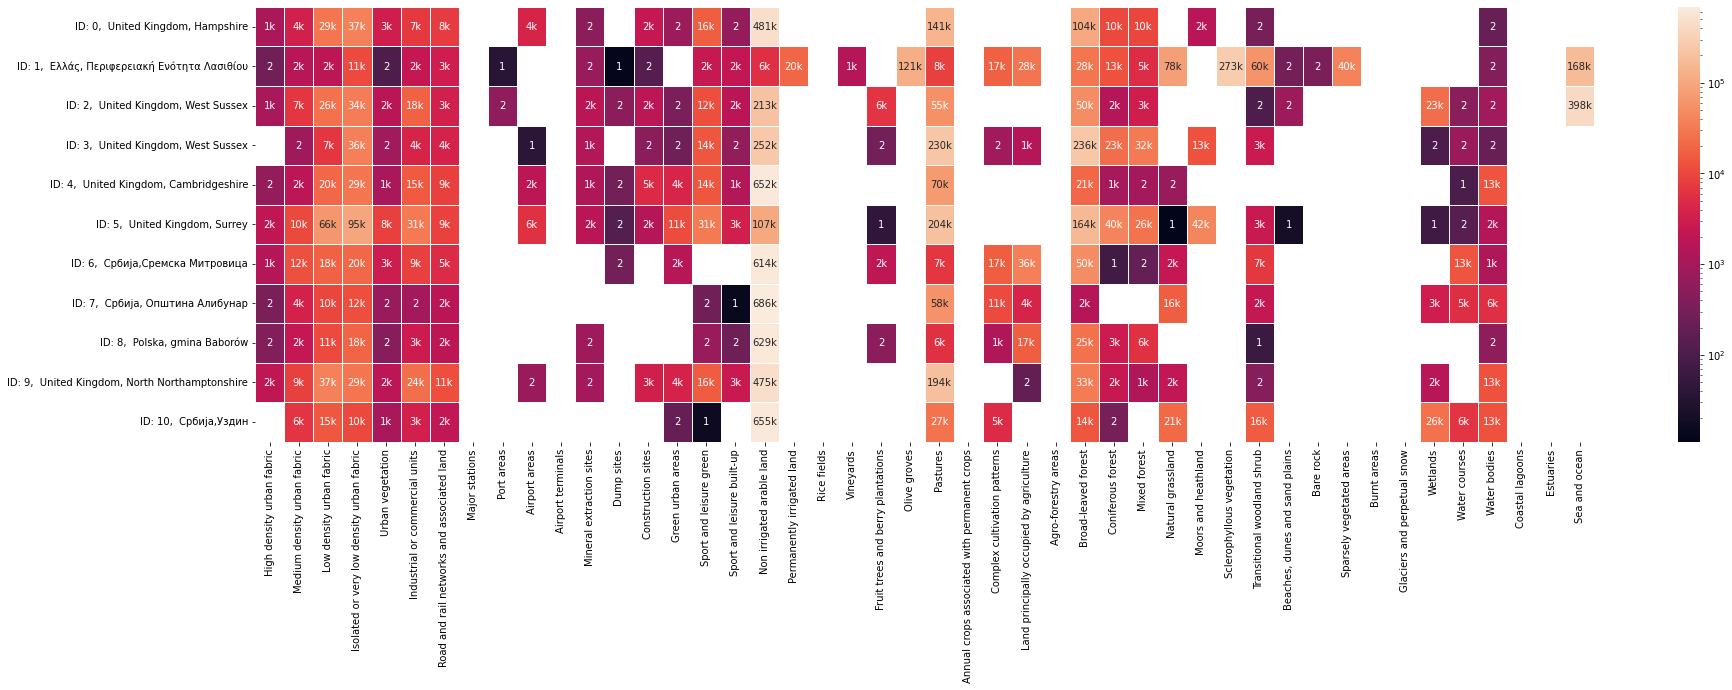

In [28]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(30,8)) 
       
ax = plt.subplot(111) 
fig.add_subplot(ax)
    
fig.set_facecolor("white")


sns.heatmap(pdf_counts, fmt='',  annot = pdf_counts_str, linewidths=.5, norm=LogNorm())


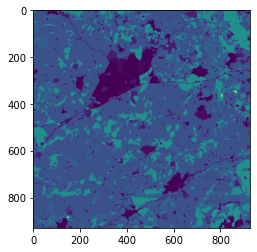

In [59]:
plt.imshow(sample_window.input_data[0])